In [32]:
import os
from collections import defaultdict
from datetime import datetime, timedelta

import h5py
import numpy as np
import pandas as pd
import matplotlib._color_data as mcd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import gridspec
from scipy.stats import mannwhitneyu
import seaborn as sns 

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-white')


In [21]:
DATA_DIR = './data/ml-1m'

In [22]:
ratings = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), sep='::', engine='python', header=None)
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [23]:
users = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'), sep='::', engine='python', header=None)
users.columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [24]:
age_mapping = {  
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49", 
    50:  "50-55",
    56:  "56+"
}

occupation_mapping = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

# assignment based on https://www.statista.com/statistics/254115/favorite-movie-genres-in-the-us/#:~:text=The%20study%20revealed%20that%20comedy,and%20action%20were%20similarly%20popular.
# TODO try to come up with better way
movie_stereotype_map = {
    "Action": 'M',
    "Adventure": 'M',
    "Animation": 'F',
    "Children's": 'NA',  # F
    "Comedy": 'NA',  # F
    "Crime": 'M',
    "Documentary": 'NA',  # F
    "Drama": 'F',
    "Fantasy": 'NA',  # M
    "Film-Noir": 'M',
    "Horror": 'M',
    "Musical": 'F',
    "Mystery": 'NA',  # M
    "Romance": 'F',
    "Sci-Fi": 'M',
    "Thriller": 'NA',  # M
    "War": 'M',
    "Western": 'M'
}

In [25]:
ratings = pd.merge(left=ratings, right=users, left_on='user_id', right_on='user_id')

In [26]:
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067


## Exploratory data analysis

In [48]:
gender_avg_rating = defaultdict(list)
gender_N_ratings = defaultdict(list)

for u_id, u_df in ratings.groupby('user_id'):
    gender = users[users['user_id'] == u_id]['gender'].tolist()[0]
    gender_avg_rating[gender].append(np.average(u_df['rating'].values))
    gender_N_ratings[gender].append(len(u_df))

The average rating a female-identifying user assigns a movie is generally higher (note this doesn't necessarily mean that the movie recommendations females receive are better - one possible explanation that we can't verify is perhaps female users tend to only rate movies that they like), and female users rate fewer movies than male users.

In [49]:
mannwhitneyu(gender_avg_rating['F'], gender_avg_rating['M'], alternative='greater')

MannwhitneyuResult(statistic=3881977.0, pvalue=0.0015015478615958843)

In [57]:
"Average rating per user: F = {0:.2f}, M = {1:.2f}".format(
    np.average(gender_avg_rating['F']), np.average(gender_avg_rating['M']))

'Average rating per user: F = 3.73, M = 3.69'

In [51]:
mannwhitneyu(gender_N_ratings['F'], gender_N_ratings['M'], alternative='less')

MannwhitneyuResult(statistic=3315703.0, pvalue=1.3998233485733903e-10)

In [58]:
"Number of ratings per user: F = {0:.2f}, M = {1:.2f}".format(
    np.average(gender_N_ratings['F']), np.average(gender_N_ratings['M']))

'Number of ratings per user: F = 144.20, M = 174.04'

What if we segment by each user's earlier and later ratings? (Ans: all users seem to rate less positively towards the second half of their time on the site)

In [60]:
early_gender_ratings = defaultdict(list)
late_gender_ratings = defaultdict(list)

for u_id, u_df in ratings.groupby('user_id'):
    u_df = u_df.sort_values('timestamp')
    gender = users[users['user_id'] == u_id]['gender'].tolist()[0]
    user_ratings = u_df['rating'].values
    half = len(u_df) // 2
    early_gender_ratings[gender].append(np.average(user_ratings[:half]))
    late_gender_ratings[gender].append(np.average(user_ratings[half:]))

In [61]:
np.average(early_gender_ratings['F']), np.average(early_gender_ratings['M'])

(3.7590748036722523, 3.738039520605692)

In [62]:
np.average(late_gender_ratings['F']), np.average(late_gender_ratings['M'])

(3.699726021907592, 3.6462406238542115)

What if we segment by users who started in the first half of MovieLens vs the second half? Note we "discard" the time period where MovieLens becomes much less popular, so in fact this is only on the first 50% of the data as a whole, dividing into the earliest 25% and then the next 25% of time.

Ans: second half of users tend to rate movies lower, and female users' ratings especially get lower.

TODO: Do the female users in the second half rate more "stereotypically male" movies? 

In [64]:
sorted_ratings = ratings.sort_values('timestamp')
sorted_ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code
1000138,6040,858,4,956703932,M,25,6,11106
1000153,6040,2384,4,956703954,M,25,6,11106
999873,6040,593,5,956703954,M,25,6,11106
1000007,6040,1961,4,956703977,M,25,6,11106
1000192,6040,2019,5,956703977,M,25,6,11106


In [71]:
early_gender_ratings = defaultdict(list)
late_gender_ratings = defaultdict(list)

sorted_users = sorted_ratings['user_id'].unique()
sorted_users = sorted_users[:len(sorted_users) // 2]
for ix, user_id in enumerate(sorted_users):
    u_df = sorted_ratings[sorted_ratings['user_id'] == user_id]
    gender = users[users['user_id'] == user_id]['gender'].tolist()[0]
    if ix < len(sorted_users) // 2:
        early_gender_ratings[gender] = np.average(u_df['rating'].values)
    else:
        late_gender_ratings[gender] = np.average(u_df['rating'].values)

In [72]:
np.average(early_gender_ratings['F']), np.average(early_gender_ratings['M'])

(3.84, 3.42798353909465)

In [73]:
np.average(late_gender_ratings['F']), np.average(late_gender_ratings['M'])

(3.25, 3.006666666666667)

## Churn rates

In [13]:
ratings['timestamp_dt'] = pd.to_datetime(ratings['timestamp'].apply(lambda d: datetime.fromtimestamp(d).strftime('%Y-%m-%d')))

In [74]:
# Daily churn rate
segments = [start + timedelta(x) for x in range(0, (end - start).days, 1)]
segments

[Timestamp('2000-04-25 00:00:00'),
 Timestamp('2000-04-26 00:00:00'),
 Timestamp('2000-04-27 00:00:00'),
 Timestamp('2000-04-28 00:00:00'),
 Timestamp('2000-04-29 00:00:00'),
 Timestamp('2000-04-30 00:00:00'),
 Timestamp('2000-05-01 00:00:00'),
 Timestamp('2000-05-02 00:00:00'),
 Timestamp('2000-05-03 00:00:00'),
 Timestamp('2000-05-04 00:00:00'),
 Timestamp('2000-05-05 00:00:00'),
 Timestamp('2000-05-06 00:00:00'),
 Timestamp('2000-05-07 00:00:00'),
 Timestamp('2000-05-08 00:00:00'),
 Timestamp('2000-05-09 00:00:00'),
 Timestamp('2000-05-10 00:00:00'),
 Timestamp('2000-05-11 00:00:00'),
 Timestamp('2000-05-12 00:00:00'),
 Timestamp('2000-05-13 00:00:00'),
 Timestamp('2000-05-14 00:00:00'),
 Timestamp('2000-05-15 00:00:00'),
 Timestamp('2000-05-16 00:00:00'),
 Timestamp('2000-05-17 00:00:00'),
 Timestamp('2000-05-18 00:00:00'),
 Timestamp('2000-05-19 00:00:00'),
 Timestamp('2000-05-20 00:00:00'),
 Timestamp('2000-05-21 00:00:00'),
 Timestamp('2000-05-22 00:00:00'),
 Timestamp('2000-05-

In [244]:
def get_churn(user_start_end, use_attr=None):
    # number of users at the start of the segment
    count_per_segment = defaultdict(int)  
    for ix, next_m in enumerate(segments[1:]):
        curr_m = segments[ix]
        for u in user_start_end:
            # if we are filtering by gender, skip if doesn't match
            if use_attr is not None and u['gender'] != use_attr:
                continue
            u_start, u_end = u['start'], u['end']
            # user starts before the segment and doesn't end before the segment
            if u_start <= curr_m and u_end > curr_m:
                count_per_segment[(curr_m, next_m)] += 1
    
    segment_dropoff = defaultdict(int)
    for ix, next_m in enumerate(segments[1:]):
        curr_m = segments[ix]
        for u in user_start_end:
            if use_attr is not None and u['gender'] != use_attr:
                continue
            u_start, u_end = u['start'], u['end']
            if u_start <= curr_m and u_end > curr_m and u_end <= next_m:
                segment_dropoff[(curr_m, next_m)] += 1
    
    
    churn_rate = {}
    for curr_m, next_m in count_per_segment.keys():
        count_users_start = count_per_segment[(curr_m, next_m)]
        users_dropped = segment_dropoff[(curr_m, next_m)]
        churn_rate[curr_m] = users_dropped / count_users_start
    return churn_rate

In [146]:
user_start_end = []
for g_id, group in ratings.groupby(by='user_id'):
    user_start_end.append({
        'user_id': g_id,
        'gender': users[users['user_id'] == g_id]['gender'].values[0],
        'start': group['timestamp_dt'].min(),
        'end': group['timestamp_dt'].max()
    })

In [245]:
churn_baseline = get_churn(user_start_end)
churn_male = get_churn(user_start_end, use_attr='M')
churn_female = get_churn(user_start_end, use_attr='F')


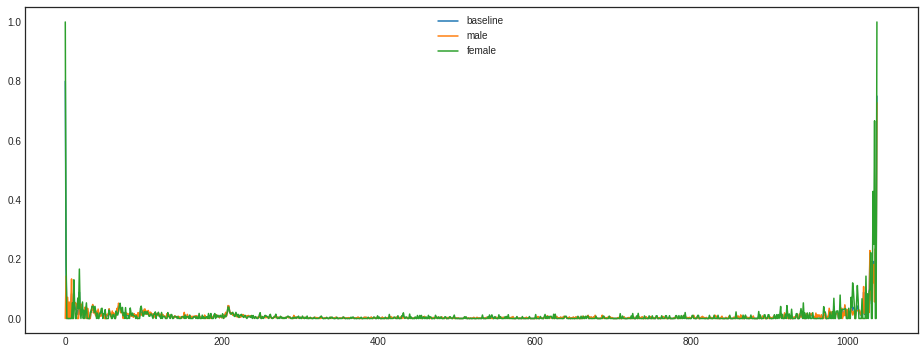

In [246]:
segments = list(churn_baseline.keys())
xs = list(range(len(segments)))

plt.figure(figsize=(16, 6))
plt.plot(xs, list(churn_baseline.values()), label='baseline')
plt.plot(xs, list(churn_male.values()), label='male')
plt.plot(xs, list(churn_female.values()), label='female')
#plt.xticks(xs, segments)
#ax = plt.gca()
#ax.set_xticklabels(segments, rotation=90)
plt.legend()

In [249]:
mannwhitneyu(list(churn_female.values()), list(churn_male.values()), alternative='less')

MannwhitneyuResult(statistic=437102.0, pvalue=2.0592924270710363e-15)

In [248]:
np.average(list(churn_baseline.values())), np.average(list(churn_male.values())), np.average(list(churn_female.values()))

(0.008975964990413586, 0.0080286178979335, 0.009839273225301266)

In [147]:
usage_df = pd.DataFrame(user_start_end)

## Not user specific, general trends

[Text(0, 0, '2000-12-31 00:00:00'),
 Text(0, 0, '2000-12-31 00:00:00'),
 Text(0, 0, '2000-12-31 00:00:00'),
 Text(0, 0, '2000-12-31 00:00:00'),
 Text(0, 0, '2001-01-06 00:00:00'),
 Text(0, 0, '2000-12-31 00:00:00'),
 Text(0, 0, '2000-12-31 00:00:00')]

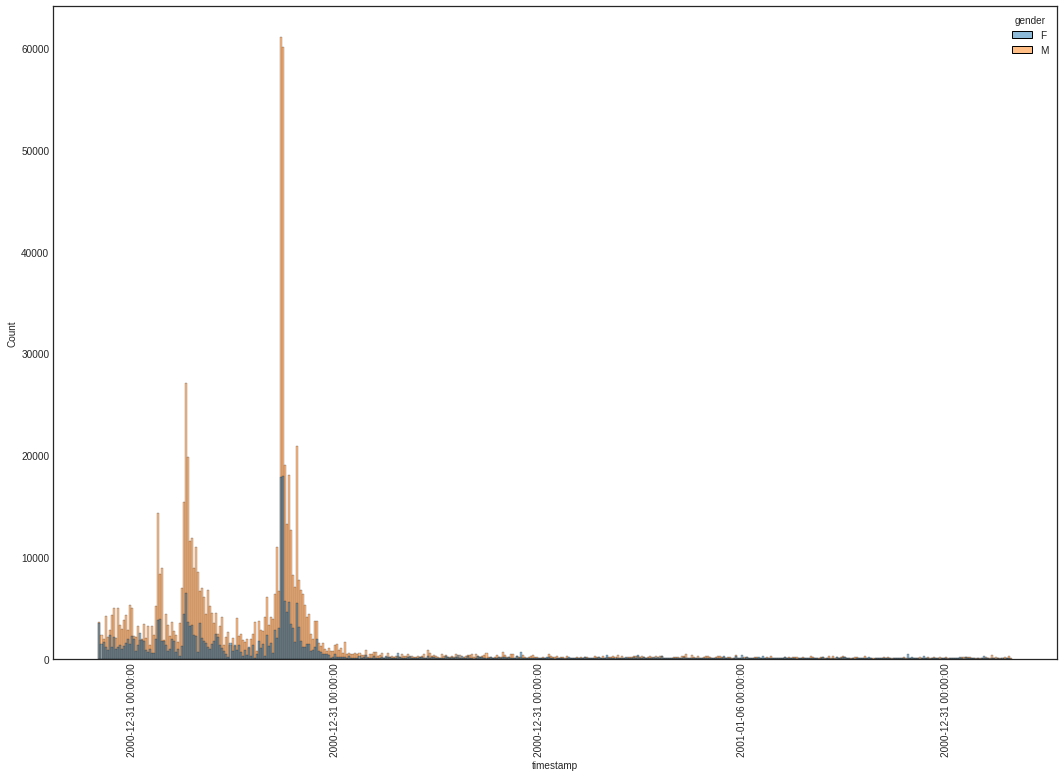

In [116]:
plt.figure(figsize=(18, 12))
ax = sns.histplot(data=ratings,
                  x='timestamp', hue='gender')
labels = pd.to_datetime(ratings['timestamp_dt'])
ax.set_xticklabels(labels, rotation=90)


In [20]:
ratings.head()

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip_code
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067


In [117]:
bins = pd.cut(ratings['timestamp'], bins=50, labels=False)
ratings['timestamp_binned'] = bins

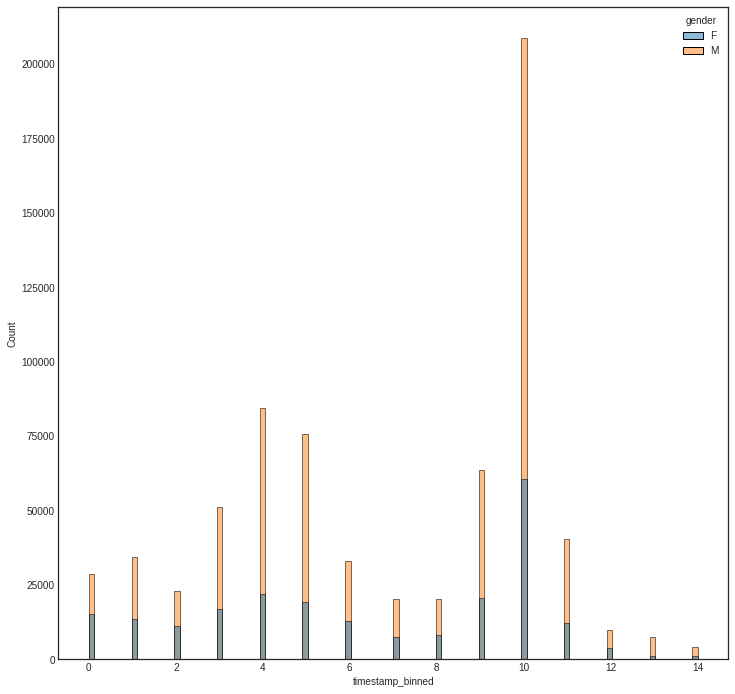

In [118]:
plt.figure(figsize=(12, 12))
sns.histplot(data=ratings[ratings['timestamp_binned'] < 15],
             x='timestamp_binned', hue='gender')

In [119]:
total_in_bin = ratings.groupby('timestamp_binned').size().values



In [120]:
timestamp_by_gender = ratings.groupby(['timestamp_binned', 'gender']).size() 
timestamp_by_gender.head()

timestamp_binned  gender
0                 F         15106
                  M         28529
1                 F         13660
                  M         34348
2                 F         11127
dtype: int64

In [121]:
prop_gender_binned = []
for label, row in timestamp_by_gender.iteritems():
    tbin, gender = label
    prop = row / total_in_bin[tbin]
    prop_gender_binned.append(
        {'timestamp_binned': tbin,
         'gender': gender,
         'gender_prop': prop
        })

In [122]:
gender_binned = pd.DataFrame(prop_gender_binned)
gender_binned.head()

,gender,gender_prop,timestamp_binned
0,F,0.346190,0
1,M,0.653810,0
2,F,0.284536,1
3,M,0.715464,1
4,F,0.327573,2


In [123]:
fgender_df = gender_binned[gender_binned['gender'] == 'F']
mgender_df = gender_binned[gender_binned['gender'] == 'M']

In [124]:
fgender_df['prop_diff'] = fgender_df['gender_prop'].values - mgender_df['gender_prop'].values

/mnt/home/kchen/anaconda3/envs/534-mB/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


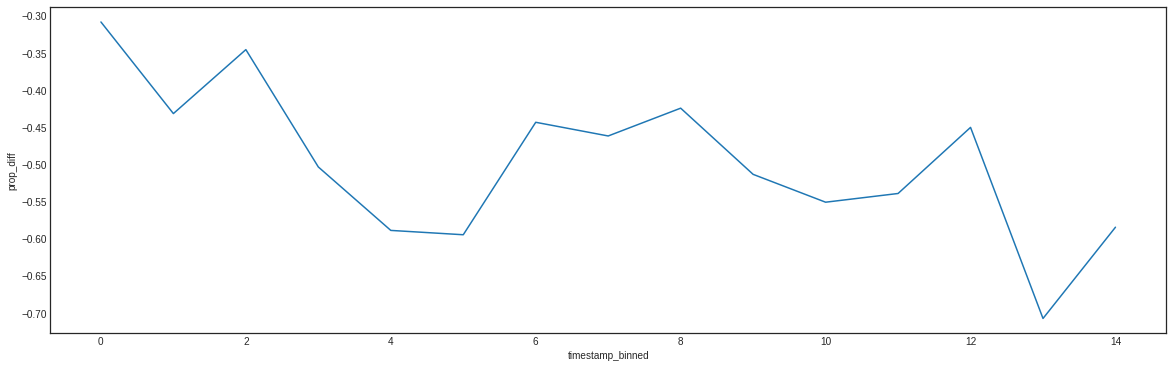

In [125]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=fgender_df[fgender_df['timestamp_binned'] < 15], 
             x='timestamp_binned', y='prop_diff',)

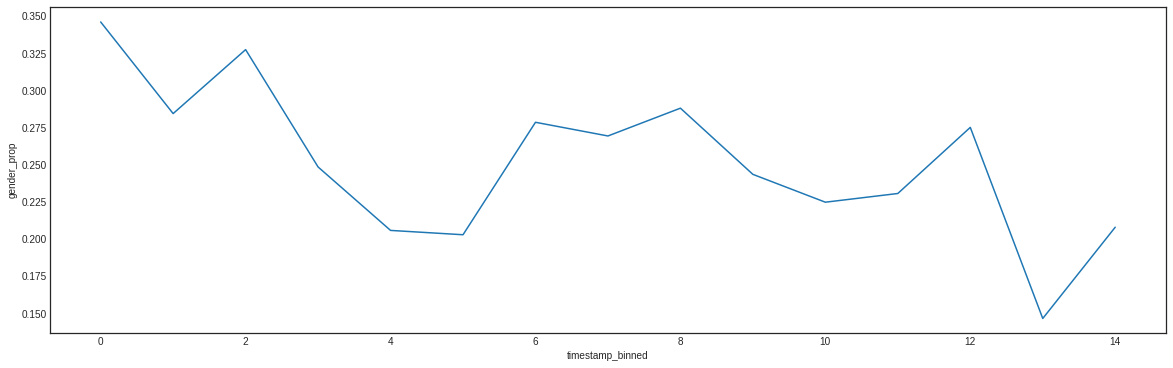

In [126]:
plt.figure(figsize=(20, 6))
f_df = gender_binned[gender_binned['gender'] == 'F']
sns.lineplot(data=f_df[f_df['timestamp_binned'] < 15], 
             x='timestamp_binned', y='gender_prop',)